In [5]:
import pandas as pd

# Charger les données JSON contenant les avis clients
df = pd.read_json('reviews.jsonl', lines=True)

# Extraire les colonnes pertinentes : texte des avis et notes réelles (ratings)
df = df[['text', 'rating']].dropna()

# Convertir les notes en entiers
df['rating'] = df['rating'].astype(int)  

# Vérification des données
print(f"Aperçu des données :\n{df.head()}")


Aperçu des données :
                                                text  rating
0  I bought this bc I thought it had the nice whi...       4
1  Perfect. How pissed am I that I recently paid ...       5
2  Overall very happy with the end result. If you...       5
3  Lasted about 9 months then the lock button bro...       4
4  LOVE THIS CASE! Works better than my expensive...       5


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Charger le modèle et le tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [3]:
#Prétratiement des données
from torch.utils.data import DataLoader, Dataset
import torch

# Classe Dataset pour préparer les données
class ReviewsDataset(Dataset):
    def __init__(self, texts, ratings):
        self.texts = texts
        self.ratings = ratings

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'text': self.texts[idx],
            'rating': self.ratings[idx]
        }

# Préparer les données
dataset = ReviewsDataset(df['text'].tolist(), df['rating'].tolist())
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [4]:
#Analyse des sentiments
from torch.nn.functional import softmax

# Détecter le dispositif (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

predicted_ratings = []

# Analyse des sentiments
for batch in dataloader:
    texts = batch['text']
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Obtenir les prédictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = softmax(logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1) + 1  # Ajouter 1 pour correspondre aux étoiles
        predicted_ratings.extend(predictions.cpu().numpy())

# Ajouter les prédictions au DataFrame
df['predicted_rating'] = predicted_ratings
print(f"Aperçu des résultats :\n{df[['rating', 'predicted_rating']].head(15)}")

Aperçu des résultats :
    rating  predicted_rating
0        4                 3
1        5                 5
2        5                 4
3        4                 2
4        5                 5
5        5                 5
6        5                 5
7        4                 5
8        5                 5
9        5                 4
10       5                 5
11       5                 5
12       5                 5
13       5                 3
14       4                 4


In [ ]:
#Performance du modèle 
# Méthode 1: Corrélation de Pearson, qui mesure la force de la relation linéaire entre deux variables continues 
#un score proche de 1 indique une relation positive forte

from scipy.stats import pearsonr

# Calculer la corrélation de Pearson entre les notes réelles et prédites
real_ratings = df['rating'].astype(float)
predicted_ratings = df['predicted_rating'].astype(float)
correlation, _ = pearsonr(real_ratings, predicted_ratings)
print(f"Corrélation de Pearson entre les notes réelles et prédites : {correlation:.3f}")

Corrélation de Pearson entre les notes réelles et prédites : 0.817


Rapport de Classification :

              precision    recall  f1-score   support

           1       0.71      0.61      0.66       101
           2       0.25      0.51      0.34        39
           3       0.33      0.49      0.39        70
           4       0.36      0.56      0.44       164
           5       0.93      0.71      0.81       626

    accuracy                           0.65      1000
   macro avg       0.52      0.58      0.53      1000
weighted avg       0.75      0.65      0.68      1000



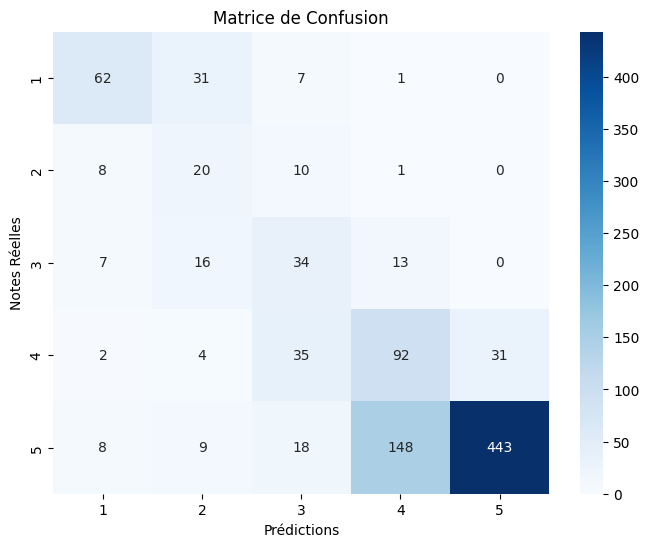

In [11]:
#Méthode 2 : métriques de classification standard comme accuracy, precision, recall, et F1-score.
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Étape 1 : Préparer les données
real_ratings = df['rating'].astype(int)  # Notes réelles
predicted_ratings = df['predicted_rating'].astype(int)  # Notes prédites

# Étape 2 : Calculer le rapport de classification
report = classification_report(real_ratings, predicted_ratings, target_names=[str(i) for i in range(1, 6)])
print("Rapport de Classification :\n")
print(report)

# Étape 3 : Matrice de Confusion
conf_matrix = confusion_matrix(real_ratings, predicted_ratings)

# Visualisation de la Matrice de Confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Notes Réelles")
plt.show()


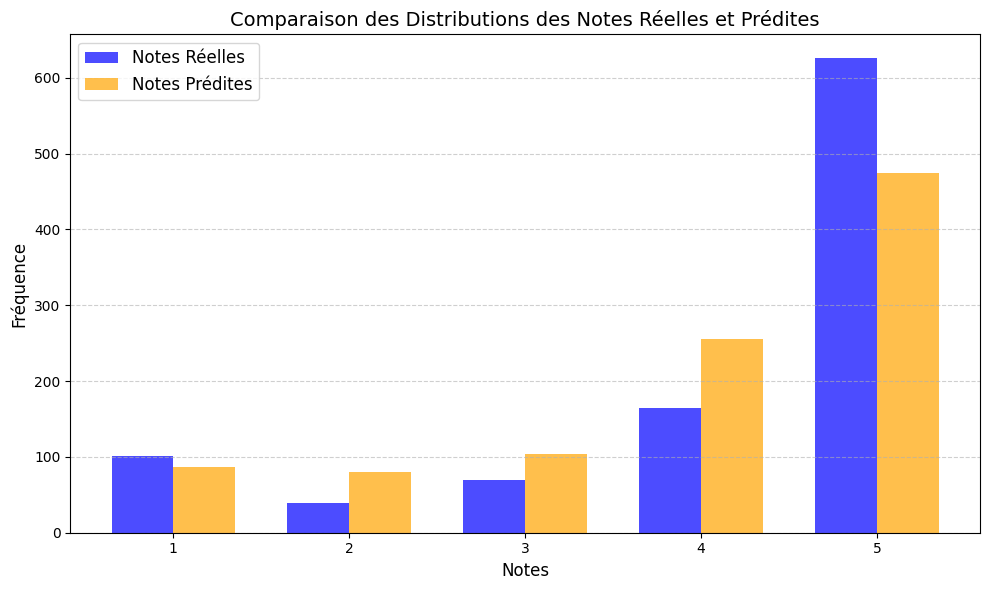

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Étape 1 : Calculer les fréquences pour chaque catégorie de note
real_counts = real_ratings.value_counts().sort_index()
predicted_counts = pd.Series(predicted_ratings).value_counts().sort_index()

# S'assurer que toutes les catégories (1 à 5) sont présentes
categories = range(1, 6)
real_counts = real_counts.reindex(categories, fill_value=0)
predicted_counts = predicted_counts.reindex(categories, fill_value=0)

# Étape 2 : Création des barres groupées
x = np.arange(len(categories))  # Positions pour les groupes
width = 0.35  # Largeur des barres

# Initialiser le graphique
plt.figure(figsize=(10, 6))

# Ajouter les barres pour les notes réelles et prédites
plt.bar(x - width/2, real_counts, width, label='Notes Réelles', color='blue', alpha=0.7)
plt.bar(x + width/2, predicted_counts, width, label='Notes Prédites', color='orange', alpha=0.7)

# Étape 3 : Personnaliser le graphique
plt.title('Comparaison des Distributions des Notes Réelles et Prédites', fontsize=14)
plt.xlabel('Notes', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.xticks(x, categories)  # Placer les catégories (1 à 5) sur l'axe x
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Afficher le graphique
plt.tight_layout()
plt.show()
